# Modelado de Clasificación - CS:GO Dataset

**Objetivo:** Entrenar modelos de clasificación para predecir supervivencia del jugador en CS:GO

**Target Principal:** Survived (supervivencia del jugador en la ronda)

**Metodología:** Comparación de 5 algoritmos con GridSearchCV y análisis de curvas ROC

---

## 1. Importación de Librerías

In [27]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn para ML
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas exitosamente")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

Librerías importadas exitosamente
Pandas version: 2.2.3
Numpy version: 2.2.6


## 2. Carga y Exploración de Datos

In [28]:
# Cargar dataset con features
try:
    df = pd.read_csv("../data/04_feature/csgo_data_with_features.csv")
    print(f"Dataset con features cargado: {df.shape}")
except FileNotFoundError:
    print("Archivo con features no encontrado. Cargando datos limpios...")
    df = pd.read_csv("../data/02_intermediate/csgo_data_clean.csv")
    print(f"Dataset limpio cargado: {df.shape}")

# Información básica
print(f"\nInformación del dataset:")
print(f"- Filas: {df.shape[0]:,}")
print(f"- Columnas: {df.shape[1]}")
print(f"- Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verificar que tenemos la variable target
target = 'EffectivenessLevel'
if target not in df.columns:
    print(f"\nADVERTENCIA: Columna {target} no encontrada")
    print(f"Columnas disponibles: {list(df.columns)}")
else:
    print(f"\nTarget variable encontrada: {target}")

# Mostrar primeras filas
print(f"\nPrimeras 5 filas:")
display(df.head())

Dataset con features cargado: (79154, 82)

Información del dataset:
- Filas: 79,154
- Columnas: 82
- Memoria: 94.64 MB

Target variable encontrada: EffectivenessLevel

Primeras 5 filas:


,Map,Team,InternalTeamId,RoundId,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,Team_encoded,RoundWinner_encoded,MatchWinner_encoded,Survived_encoded,Map_de_dust2,Map_de_inferno,Map_de_mirage,Map_de_nuke,Kill_Equipment_Efficiency,Assist_Equipment_Efficiency,Headshot_Kill_Ratio,Assist_Kill_Ratio,Flank_Kill_Ratio,Match_Kill_Per_Round,Match_Assist_Per_Round,Match_Headshot_Percentage,Total_Combat_Actions,Total_Match_Actions,Kill_Performance_Level,Equipment_Investment_Level,EffectivenessScore,EffectivenessLevel,Dominant_Weapon,Weapon_Specialization_Score,Weapon_Diversity,Prefers_Rifles,Prefers_AWP,Prefers_SMG,Total_Grenades_Used,Grenade_Lethality_Ratio,Utility_Usage_Ratio,Grenade_Usage_Style,Grenades_Per_Kill,Equipment_To_Grenade_Ratio,Round_Phase,Is_Pistol_Round,Is_Anti_Eco_Round,Is_Buy_Round,Match_Progress_Percentage,Rounds_Remaining,Is_Match_Point,Is_Critical_Round,Round_Type,Early_Round_Performance,Late_Round_Performance,Individual_Equipment_Share,Team_Economic_Strength,Above_Team_Average_Equipment,Equipment_Advantage_Ratio,Likely_Entry_Fragger,Likely_Support_Player,Equipment_ROI,Equipment_Kills_Interaction,Round_Kills_Interaction,Round_Equipment_Interaction,Team_Map_Combination,Kills_Assists_Synergy,Equipment_Grenades_Synergy
0,de_inferno,Terrorist,1,1,False,True,False,0,4,0.0,0.0,0.0,0.0,1,0,0,0,0,750,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Eco,0,Bajo,PrimaryPistol,1.0,1,0,0,0,4,0.000000,0.800000,Aggressive,4.0,0.624480,Early,1,0,0,3.333333,29,0,0,Eco,0,0,0.170416,Very_Poor,0,0.851305,0,0,0.0,0,0,750,Terrorist_de_inferno,0,3000
1,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,800,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Eco,0,Bajo,PrimaryPistol,1.0,1,0,0,0,0,0.000000,0.000000,Conservative,0.0,800.000000,Early,1,0,0,3.333333,29,0,0,Eco,0,0,0.181777,Very_Poor,0,0.908059,0,0,0.0,0,0,800,Terrorist_de_inferno,0,0
2,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Force_Buy,0,Bajo,PrimaryPistol,1.0,1,0,0,0,0,0.000000,0.000000,Conservative,0.0,1000.000000,Early,1,0,0,3.333333,29,0,0,Pistol,0,0,0.227221,Very_Poor,1,1.135074,0,0,0.0,0,0,1000,Terrorist_de_inferno,0,0
3,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,850,4400,0,0,0,0,1,0,1,0,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Force_Buy,0,Bajo,PrimaryPistol,1.0,1,0,0,0,0,0.000000,0.000000,Conservative,0.0,850.000000,Early,1,0,0,3.333333,29,0,0,Eco,0,0,0.193138,Very_Poor,0,0.964813,0,0,0.0,0,0,850,Terrorist_de_inferno,0,0
4,de_inferno,Terrorist,1,1,False,True,True,1,1,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,1,False,True,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,No_Kills,Force_Buy,0,Bajo,PrimaryPistol,1.0,1,0,0,0,2,0.333333,0.333333,Moderate,2.0,1.663894,Early,1,0,0,3.333333,29,0,0,Pistol,0,0,0.227221,Very_Poor,1,1.135074,0,0,0.0,0,0,1000,Terrorist_de_inferno,0,2000


## 3. Análisis del Target y Balanceamiento

ANÁLISIS DEL TARGET: EffectivenessLevel
Target original: {'Bajo': 37301, 'Medio': 25499, 'Alto': 16354}
Target codificado: {1: 37301, 2: 25499, 0: 16354}
Mapeo: {'Alto': np.int64(0), 'Bajo': np.int64(1), 'Medio': np.int64(2)}

Distribución del target:
Clase 1: 37,301 (0.471)
Clase 2: 25,499 (0.322)
Clase 0: 16,354 (0.207)

Análisis de balanceamiento:
Ratio minority/majority: 0.438
Estado: DESBALANCEADO


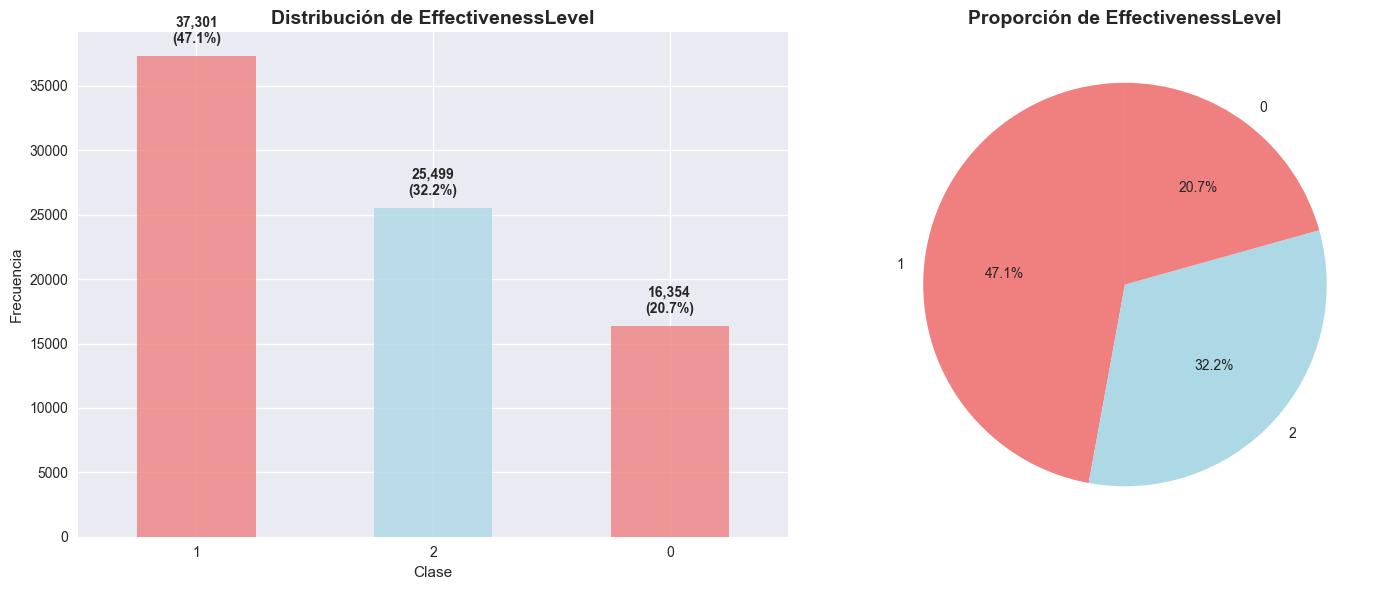

In [29]:
# Analizar target variable
print(f"ANÁLISIS DEL TARGET: {target}")
print("=" * 40)

# Convertir a numérico si es necesario
if df[target].dtype == 'object' or df[target].dtype == 'bool':
    le = LabelEncoder()
    df[target + '_encoded'] = le.fit_transform(df[target])
    target_encoded = target + '_encoded'
    
    print(f"Target original: {df[target].value_counts().to_dict()}")
    print(f"Target codificado: {df[target_encoded].value_counts().to_dict()}")
    print(f"Mapeo: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    target_col = target_encoded
else:
    target_col = target

# Distribución del target
target_counts = df[target_col].value_counts()
target_props = df[target_col].value_counts(normalize=True)

print(f"\nDistribución del target:")
for val, count in target_counts.items():
    prop = target_props[val]
    print(f"Clase {val}: {count:,} ({prop:.3f})")

# Verificar balanceamiento
minority_prop = min(target_props)
majority_prop = max(target_props)
balance_ratio = minority_prop / majority_prop

print(f"\nAnálisis de balanceamiento:")
print(f"Ratio minority/majority: {balance_ratio:.3f}")

if balance_ratio >= 0.8:
    balance_status = "BIEN BALANCEADO"
elif balance_ratio >= 0.6:
    balance_status = "MODERADAMENTE BALANCEADO"
else:
    balance_status = "DESBALANCEADO"

print(f"Estado: {balance_status}")

# Visualización del target
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
target_counts.plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightblue'], alpha=0.8)
axes[0].set_title(f'Distribución de {target}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Añadir etiquetas a las barras
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + len(df)*0.01, f'{v:,}\n({target_props.iloc[i]:.1%})', 
                ha='center', va='bottom', fontweight='bold')

# Gráfico circular
axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
           colors=['lightcoral', 'lightblue'], startangle=90)
axes[1].set_title(f'Proporción de {target}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Selección de Features

Features candidatas: 56
Primeras 10 features: ['RoundId', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'RoundKills', 'RoundAssists']

Top 15 correlaciones con EffectivenessLevel:
 1. RoundKills                    : 0.398 (-)
 2. EffectivenessScore            : 0.395 (-)
 3. Equipment_Kills_Interaction   : 0.375 (-)
 4. Total_Combat_Actions          : 0.368 (-)
 5. Kills_Assists_Synergy         : 0.349 (-)
 6. Round_Kills_Interaction       : 0.325 (-)
 7. RoundHeadshots                : 0.264 (-)
 8. Likely_Support_Player         : 0.187 (+)
 9. RoundFlankKills               : 0.165 (-)
10. Early_Round_Performance       : 0.161 (-)
11. Assist_Kill_Ratio             : 0.160 (+)
12. Survived_encoded              : 0.119 (-)
13. Headshot_Kill_Ratio           : 0.111 (-)
14. RoundWinner_encoded           : 0.095 (+)
15. Grenades_Per_Kill             : 0.089 (+)


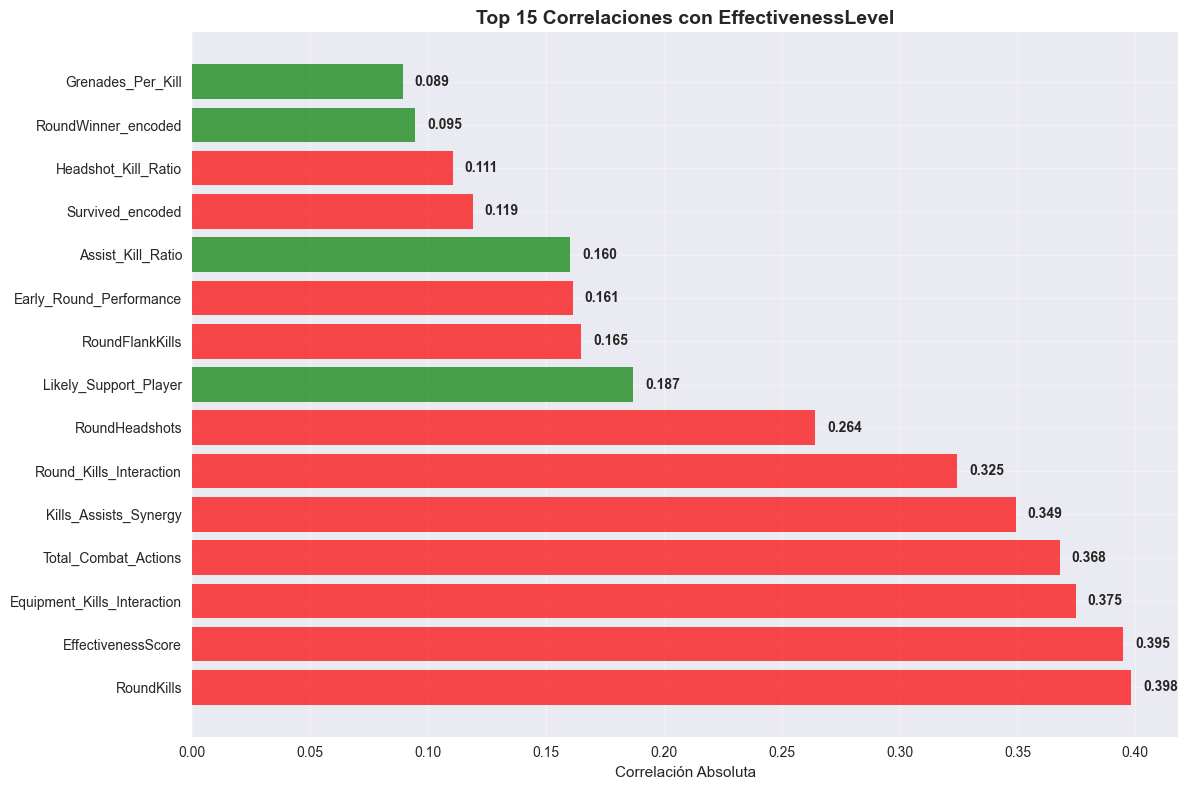

In [30]:
# Seleccionar features numéricas (excluyendo target y variables problemáticas)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir variables que causan data leakage o son irrelevantes
exclude_features = [
    target, target_col,  # Target variables
    'RoundWinner', 'MatchWinner',  # Resultado de la ronda/match (data leakage)
    'MatchKills', 'MatchAssists', 'MatchHeadshots', 'MatchFlankKills',  # Métricas de match completo
    'Total_Match_Actions', 'Match_Kill_Per_Round', 'Match_Assist_Per_Round',  # Derivadas de match
    'Cumulative_Kills',  # Acumulativa de kills
    'Team_Win_Rate',  # Podría causar leakage temporal
    'Unnamed: 0', 'MatchId', 'InternalTeamId', 'Player_ID'  # IDs
]

# Filtrar features candidatas
candidate_features = [f for f in numeric_features if f not in exclude_features]

print(f"Features candidatas: {len(candidate_features)}")
print(f"Primeras 10 features: {candidate_features[:10]}")

# Calcular correlación con el target
correlations = df[candidate_features + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
correlations = correlations.drop(target_col)  # Remover autocorrelación

print(f"\nTop 15 correlaciones con {target}:")
for i, (feature, corr) in enumerate(correlations.head(15).items()):
    direction = "(+)" if df[feature].corr(df[target_col]) > 0 else "(-)"
    print(f"{i+1:2d}. {feature:30s}: {corr:.3f} {direction}")

# Visualizar top correlaciones
plt.figure(figsize=(12, 8))
top_corr = correlations.head(15)
colors = ['green' if df[feature].corr(df[target_col]) > 0 else 'red' for feature in top_corr.index]

plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlación Absoluta')
plt.title(f'Top 15 Correlaciones con {target}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Añadir valores a las barras
for i, v in enumerate(top_corr.values):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [31]:
# Selección final de features evitando multicolinealidad
selected_features = [
    'RoundKills',                    # Más kills = mayor probabilidad supervivencia
    'RoundAssists',                  # Asistencias indican participación
    'Total_Combat_Actions',          # Actividad general en combate
    'RoundStartingEquipmentValue',   # Mejor equipamiento = mayor supervivencia
    'Equipment_ROI',                 # Eficiencia del equipamiento
    'Team_Coordination_Score',       # Coordinación del equipo
    'RLethalGrenadesThrown',         # Uso táctico de granadas
    'RNonLethalGrenadesThrown',      # Utilidades para supervivencia
    'Individual_Equipment_Share',    # Proporción de equipamiento del jugador
    'Kill_Equipment_Efficiency',     # Eficiencia individual
    'RoundId',                       # Progreso de la partida
    'Equipment_Kills_Interaction',   # Interacción equipamiento-rendimiento
    'Above_Team_Average_Equipment',  # Ventaja relativa en equipamiento
    'Team_Total_Kills',             # Rendimiento del equipo
    'Round_Equipment_Interaction'    # Interacción ronda-equipamiento
]

# Verificar que las features existen
available_features = [f for f in selected_features if f in df.columns]
missing_features = [f for f in selected_features if f not in df.columns]

if missing_features:
    print(f"Features faltantes: {missing_features}")
    selected_features = available_features

print(f"\nFEATURES SELECCIONADAS PARA CLASIFICACIÓN: {len(selected_features)}")
for i, feature in enumerate(selected_features):
    if feature in df.columns:
        corr_with_target = df[feature].corr(df[target_col])
        print(f"{i+1:2d}. {feature:30s}: r = {corr_with_target:.3f}")

# Verificar valores nulos
null_counts = df[selected_features + [target_col]].isnull().sum()
if null_counts.sum() > 0:
    print(f"\nValores nulos encontrados:")
    print(null_counts[null_counts > 0])
    
    # Imputar valores nulos si es necesario
    for col in selected_features:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"Imputados valores nulos en {col} con la mediana")
else:
    print(f"\nNo hay valores nulos en las features seleccionadas")

Features faltantes: ['Team_Coordination_Score', 'Team_Total_Kills']

FEATURES SELECCIONADAS PARA CLASIFICACIÓN: 13
 1. RoundKills                    : r = -0.398
 2. RoundAssists                  : r = -0.019
 3. Total_Combat_Actions          : r = -0.368
 4. RoundStartingEquipmentValue   : r = -0.032
 5. Equipment_ROI                 : r = -0.019
 6. RLethalGrenadesThrown         : r = -0.046
 7. RNonLethalGrenadesThrown      : r = -0.018
 8. Individual_Equipment_Share    : r = -0.008
 9. Kill_Equipment_Efficiency     : r = -0.020
10. RoundId                       : r = -0.004
11. Equipment_Kills_Interaction   : r = -0.375
12. Above_Team_Average_Equipment  : r = -0.012
13. Round_Equipment_Interaction   : r = -0.022

No hay valores nulos en las features seleccionadas


## 5. Preparación de Datos

Shape de X: (79154, 13)
Shape de y: (79154,)
Distribución de y: {1: 37301, 2: 25499, 0: 16354}

División train/test:
X_train: (63323, 13)
X_test: (15831, 13)
y_train distribución: {1: 29841, 2: 20399, 0: 13083}
y_test distribución: {1: 7460, 2: 5100, 0: 3271}

Datos escalados exitosamente
Media de X_train_scaled: 0.000000
Std de X_train_scaled: 1.000008


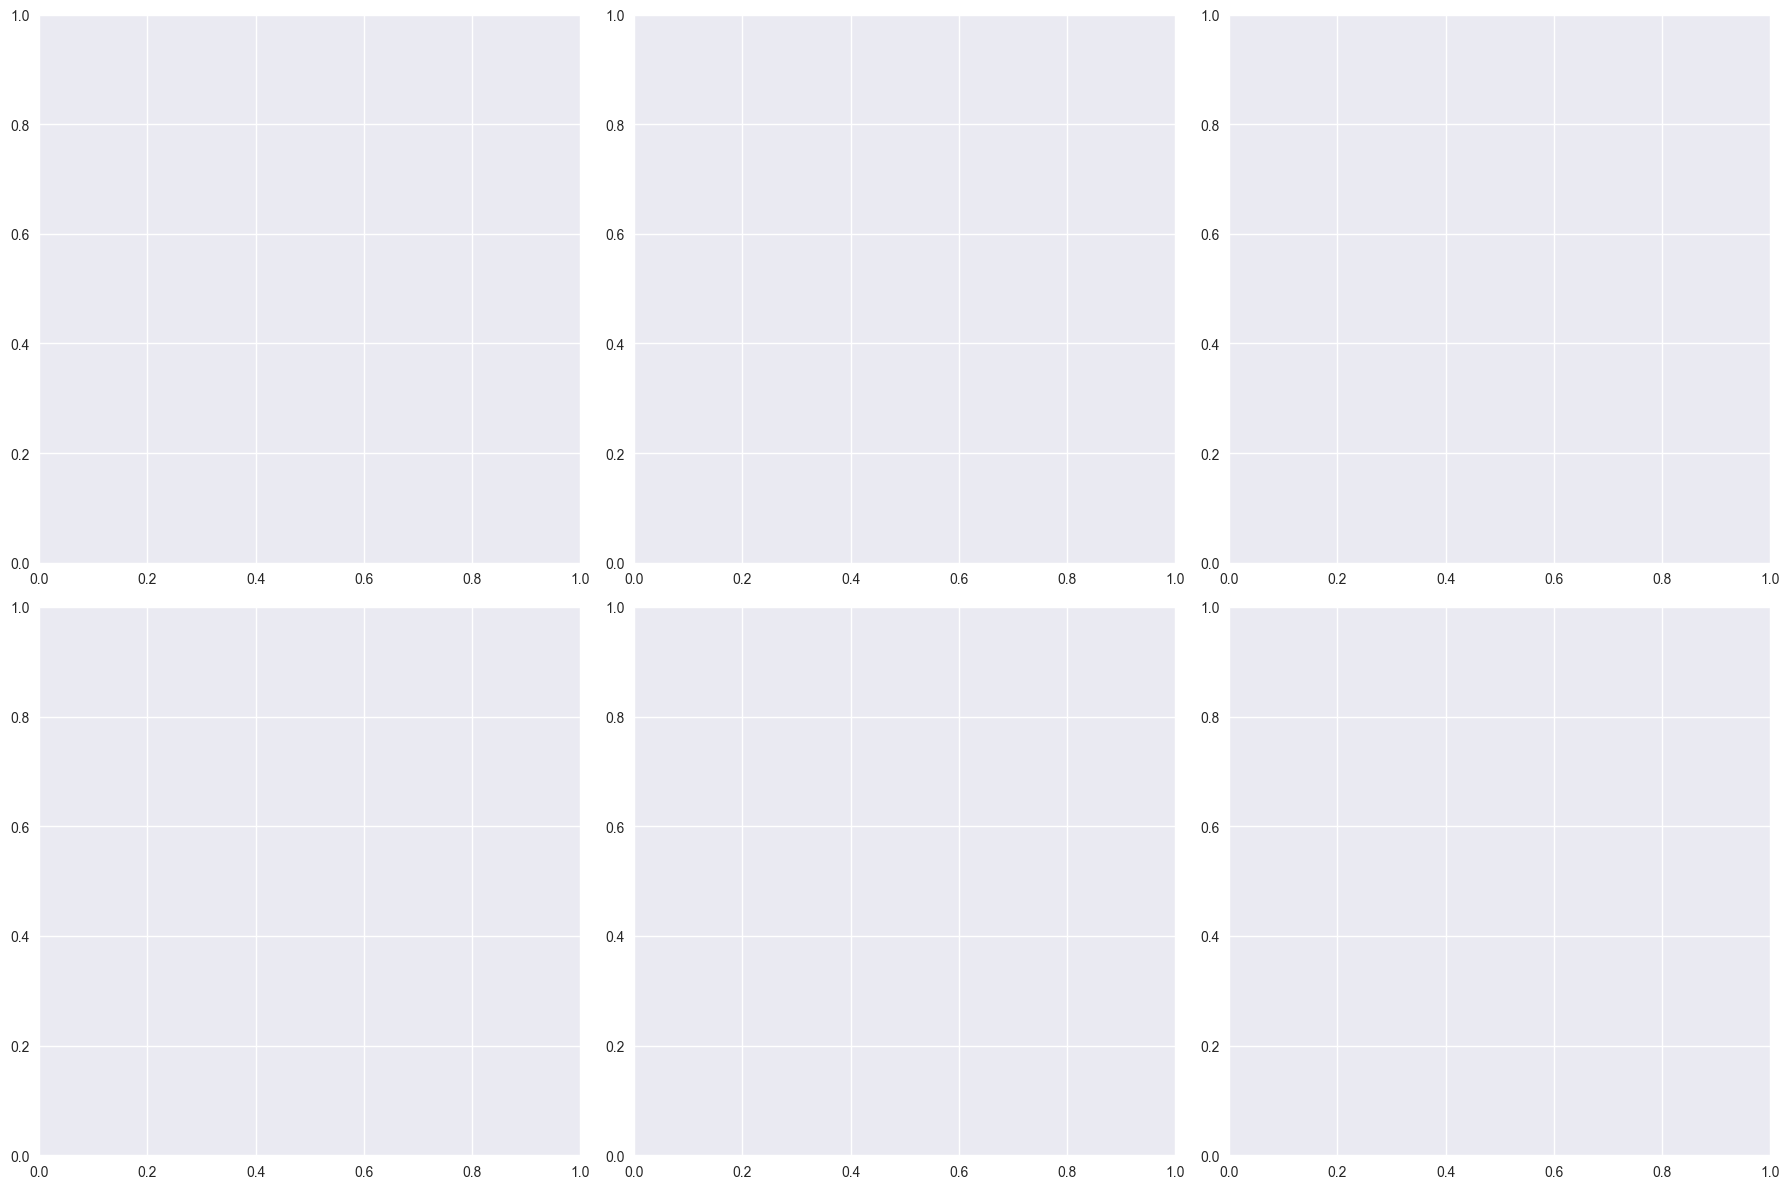

In [32]:
# Preparar datos para modelado
X = df[selected_features].copy()
y = df[target_col].copy()

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Distribución de y: {y.value_counts().to_dict()}")

# Split estratificado train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDivisión train/test:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train distribución: {y_train.value_counts().to_dict()}")
print(f"y_test distribución: {y_test.value_counts().to_dict()}")

# Escalado de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

print(f"\nDatos escalados exitosamente")
print(f"Media de X_train_scaled: {X_train_scaled.mean().mean():.6f}")
print(f"Std de X_train_scaled: {X_train_scaled.std().mean():.6f}")

# Visualizar distribución de algunas features clave
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

key_features = ['RoundHeadshots', 'GrenadeEffectiveness']

for i, feature in enumerate(key_features):
    if feature in selected_features:
        # Separar por clase
        class_0 = X_train[y_train == 0][feature]
        class_1 = X_train[y_train == 1][feature]
        
        axes[i].hist(class_0, bins=30, alpha=0.7, label='No Sobrevivió', color='red')
        axes[i].hist(class_1, bins=30, alpha=0.7, label='Sobrevivió', color='blue')
        axes[i].set_title(f'Distribución de {feature}', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frecuencia')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Definición de Modelos y Parámetros

In [35]:
# Definir modelos y sus parámetros para GridSearch
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.1, 1.0, 10.0, 100.0],
            'solver': ['liblinear', 'lbfgs'],
            'penalty': ['l1', 'l2']
        }
    },
    'Support Vector Classifier': {
        'model': SVC(random_state=42, class_weight='balanced', probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'kernel': ['rbf', 'linear']
        }
    }
}

print(f"MODELOS DEFINIDOS: {len(models)}")
for name, config in models.items():
    param_combinations = 1
    for param, values in config['params'].items():
        param_combinations *= len(values)
    print(f"- {name}: {param_combinations} combinaciones de parámetros")

print(f"\nConfiguración de GridSearchCV:")
print(f"- Validación cruzada: 5-fold estratificada")
print(f"- Métrica de scoring: ROC AUC")
print(f"- Class weight: balanced para modelos que lo soportan")
print(f"- Paralelización: todos los núcleos disponibles")

MODELOS DEFINIDOS: 5
- Random Forest: 16 combinaciones de parámetros
- Gradient Boosting: 81 combinaciones de parámetros
- XGBoost: 81 combinaciones de parámetros
- Logistic Regression: 16 combinaciones de parámetros
- Support Vector Classifier: 32 combinaciones de parámetros

Configuración de GridSearchCV:
- Validación cruzada: 5-fold estratificada
- Métrica de scoring: ROC AUC
- Class weight: balanced para modelos que lo soportan
- Paralelización: todos los núcleos disponibles


## 7. Entrenamiento de Modelos con GridSearchCV

In [40]:
# Diccionario para almacenar resultados
results = {}
best_models = {}

print("INICIANDO ENTRENAMIENTO CON GRIDSEARCHCV")
print("=" * 50)

# Configurar validación cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, config in models.items():
    print(f"\nEntrenando {name}...")
    
    # Ajustar parámetros para Logistic Regression
    if name == 'Logistic Regression':
        # Filtrar combinaciones inválidas (l1 no funciona con lbfgs)
        param_grid = []
        for C in config['params']['C']:
            for solver in config['params']['solver']:
                for penalty in config['params']['penalty']:
                    if not (solver == 'lbfgs' and penalty == 'l1'):
                        param_grid.append({'C': C, 'solver': solver, 'penalty': penalty})
        
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=param_grid,
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
    else:
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
    
    # Entrenar
    if name in ['Logistic Regression', 'Support Vector Classifier']:
        # Usar datos escalados para modelos sensibles a escala
        grid_search.fit(X_train_scaled, y_train)
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        # Usar datos originales para modelos basados en árboles
        grid_search.fit(X_train, y_train)
        X_train_used = X_train
        X_test_used = X_test
    
    # Mejores parámetros
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Predicciones
    y_train_pred = grid_search.predict(X_train_used)
    y_test_pred = grid_search.predict(X_test_used)
       # Obtener las probabilidades completas
    y_train_proba = grid_search.predict_proba(X_train_used)
    y_test_proba = grid_search.predict_proba(X_test_used)

    # Calcular AUC correctamente según el número de clases
    if len(np.unique(y_train)) == 2:
        # Binario: usar la probabilidad de la clase positiva
        train_auc = roc_auc_score(y_train, y_train_proba[:, 1])
        test_auc = roc_auc_score(y_test, y_test_proba[:, 1])
    else:
        # Multiclase: usar todas las probabilidades y los parámetros correctos
        train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
        test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
    
    # Métricas
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Almacenar resultados
    results[name] = {
        'best_params': best_params,
        'cv_auc': best_score,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_train_proba': y_train_proba,
        'y_test_proba': y_test_proba
    }
    
    best_models[name] = grid_search.best_estimator_
    
    print(f"  CV AUC: {best_score:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test AUC: {test_auc:.4f}")
    print(f"  Test F1: {test_f1:.4f}")
    print(f"  Mejores parámetros: {best_params}")

print(f"\nENTRENAMIENTO COMPLETADO")
print("=" * 30)

INICIANDO ENTRENAMIENTO CON GRIDSEARCHCV

Entrenando Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
  CV AUC: nan
  Test Accuracy: 1.0000
  Test AUC: 1.0000
  Test F1: 1.0000
  Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Entrenando Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
  CV AUC: nan
  Test Accuracy: 1.0000
  Test AUC: 1.0000
  Test F1: 1.0000
  Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Entrenando XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
  CV AUC: nan
  Test Accuracy: 1.0000
  Test AUC: 1.0000
  Test F1: 1.0000
  Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Entrenando Logistic Regression...


TypeError: Parameter grid for parameter 'C' needs to be a list or a numpy array, but got 0.1 (of type float) instead. Single values need to be wrapped in a list with one element.

## 8. Comparación de Resultados

In [ ]:
# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_AUC': [results[model]['cv_auc'] for model in results.keys()],
    'Train_Accuracy': [results[model]['train_accuracy'] for model in results.keys()],
    'Test_Accuracy': [results[model]['test_accuracy'] for model in results.keys()],
    'Train_Precision': [results[model]['train_precision'] for model in results.keys()],
    'Test_Precision': [results[model]['test_precision'] for model in results.keys()],
    'Train_Recall': [results[model]['train_recall'] for model in results.keys()],
    'Test_Recall': [results[model]['test_recall'] for model in results.keys()],
    'Train_F1': [results[model]['train_f1'] for model in results.keys()],
    'Test_F1': [results[model]['test_f1'] for model in results.keys()],
    'Train_AUC': [results[model]['train_auc'] for model in results.keys()],
    'Test_AUC': [results[model]['test_auc'] for model in results.keys()]
})

# Ordenar por Test AUC
results_df = results_df.sort_values('Test_AUC', ascending=False).reset_index(drop=True)

print("COMPARACIÓN DE RESULTADOS")
print("=" * 40)
display(results_df.round(4))

# Identificar mejor modelo
best_model_name = results_df.iloc[0]['Model']
best_test_auc = results_df.iloc[0]['Test_AUC']

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"Test AUC: {best_test_auc:.4f}")
print(f"Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")
print(f"Test F1: {results_df.iloc[0]['Test_F1']:.4f}")

# Verificar overfitting/underfitting
print(f"\nANÁLISIS DE OVERFITTING/UNDERFITTING:")
for idx, row in results_df.iterrows():
    model_name = row['Model']
    train_auc = row['Train_AUC']
    test_auc = row['Test_AUC']
    diff = train_auc - test_auc
    
    if diff > 0.1:
        status = "OVERFITTING"
    elif test_auc < 0.7:
        status = "UNDERFITTING"
    else:
        status = "BUENO"
    
    print(f"{model_name:25s}: Train={train_auc:.3f}, Test={test_auc:.3f}, Diff={diff:.3f} [{status}]")

In [ ]:
# Visualización de resultados
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de AUC scores
x_pos = np.arange(len(results_df))
width = 0.35

axes[0,0].bar(x_pos - width/2, results_df['Train_AUC'], width, label='Train AUC', alpha=0.8, color='skyblue')
axes[0,0].bar(x_pos + width/2, results_df['Test_AUC'], width, label='Test AUC', alpha=0.8, color='orange')
axes[0,0].set_xlabel('Modelos')
axes[0,0].set_ylabel('AUC Score')
axes[0,0].set_title('Comparación AUC Score: Train vs Test', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Objetivo AUC = 0.8')

# 2. F1 Score Comparison
axes[0,1].bar(x_pos - width/2, results_df['Train_F1'], width, label='Train F1', alpha=0.8, color='lightgreen')
axes[0,1].bar(x_pos + width/2, results_df['Test_F1'], width, label='Test F1', alpha=0.8, color='lightcoral')
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_title('Comparación F1 Score: Train vs Test', fontweight='bold')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Test AUC ranking
axes[1,0].barh(range(len(results_df)), results_df['Test_AUC'], color='purple', alpha=0.7)
axes[1,0].set_yticks(range(len(results_df)))
axes[1,0].set_yticklabels(results_df['Model'])
axes[1,0].set_xlabel('Test AUC Score')
axes[1,0].set_title('Ranking de Modelos por Test AUC', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axvline(x=0.8, color='green', linestyle='--', alpha=0.7)

# Añadir valores a las barras
for i, v in enumerate(results_df['Test_AUC']):
    axes[1,0].text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

# 4. Métricas múltiples del mejor modelo
best_metrics = {
    'Accuracy': results_df.iloc[0]['Test_Accuracy'],
    'Precision': results_df.iloc[0]['Test_Precision'],
    'Recall': results_df.iloc[0]['Test_Recall'],
    'F1-Score': results_df.iloc[0]['Test_F1'],
    'AUC': results_df.iloc[0]['Test_AUC']
}

metric_names = list(best_metrics.keys())
metric_values = list(best_metrics.values())

axes[1,1].bar(metric_names, metric_values, color=['gold', 'lightblue', 'lightgreen', 'orange', 'purple'], alpha=0.8)
axes[1,1].set_ylabel('Score')
axes[1,1].set_title(f'Métricas del Mejor Modelo: {best_model_name}', fontweight='bold')
axes[1,1].set_ylim(0, 1)
axes[1,1].grid(True, alpha=0.3)

# Añadir valores a las barras
for i, v in enumerate(metric_values):
    axes[1,1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Análisis de Curvas ROC

In [ ]:
# Generar curvas ROC para todos los modelos
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (model_name, model_results) in enumerate(results.items()):
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test, model_results['y_test_proba'])
    auc_score = model_results['test_auc']
    
    # Plotear curva ROC
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{model_name} (AUC = {auc_score:.3f})')

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.7, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Añadir línea de referencia para AUC = 0.8
plt.axhline(y=0.8, color='green', linestyle=':', alpha=0.7, label='Objetivo TPR = 0.8')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Tabla resumen de AUC
auc_summary = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC_Score': [results[model]['test_auc'] for model in results.keys()],
    'Status': ['EXCELENTE' if results[model]['test_auc'] >= 0.9 else 
               'BUENO' if results[model]['test_auc'] >= 0.8 else 
               'ACEPTABLE' if results[model]['test_auc'] >= 0.7 else 'POBRE' 
               for model in results.keys()]
}).sort_values('AUC_Score', ascending=False)

print("\nRESUMEN DE AUC SCORES:")
print("=" * 35)
display(auc_summary)

## 10. Matrices de Confusión

In [ ]:
# Matrices de confusión para todos los modelos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (model_name, model_results) in enumerate(results.items()):
    # Calcular matriz de confusión
    cm = confusion_matrix(y_test, model_results['y_test_pred'])
    
    # Normalizar para mostrar porcentajes
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Crear heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['No Sobrevivió', 'Sobrevivió'],
                yticklabels=['No Sobrevivió', 'Sobrevivió'],
                ax=axes[i])
    
    axes[i].set_title(f'{model_name}\nAccuracy: {model_results["test_accuracy"]:.3f}', 
                     fontweight='bold')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
    
    # Añadir números absolutos
    for j in range(2):
        for k in range(2):
            axes[i].text(k+0.5, j+0.7, f'n={cm[j,k]}', 
                        ha='center', va='center', fontsize=10, color='red')

# Ocultar el subplot extra
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

# Reporte de clasificación del mejor modelo
best_model_results = results[best_model_name]
print(f"\nREPORTE DE CLASIFICACIÓN - {best_model_name}")
print("=" * 50)
print(classification_report(y_test, best_model_results['y_test_pred'], 
                          target_names=['No Sobrevivió', 'Sobrevivió']))

## 11. Análisis Detallado del Mejor Modelo

In [ ]:
# Análisis del mejor modelo
best_model = best_models[best_model_name]
best_results = results[best_model_name]

print(f"ANÁLISIS DETALLADO: {best_model_name}")
print("=" * 50)
print(f"Mejores hiperparámetros:")
for param, value in best_results['best_params'].items():
    print(f"  {param}: {value}")

print(f"\nMétricas de rendimiento:")
print(f"  CV AUC Score: {best_results['cv_auc']:.4f}")
print(f"  Test Accuracy: {best_results['test_accuracy']:.4f}")
print(f"  Test Precision: {best_results['test_precision']:.4f}")
print(f"  Test Recall: {best_results['test_recall']:.4f}")
print(f"  Test F1-Score: {best_results['test_f1']:.4f}")
print(f"  Test AUC: {best_results['test_auc']:.4f}")

# Feature importance (si está disponible)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportancia de features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:.4f}")
    
    # Visualizar feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title(f'Top 10 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # Para modelos lineales
    feature_coef = pd.DataFrame({
        'feature': selected_features,
        'coefficient': best_model.coef_[0],
        'abs_coefficient': np.abs(best_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\nCoeficientes del modelo:")
    for idx, row in feature_coef.head(10).iterrows():
        print(f"  {row['feature']:30s}: {row['coefficient']:8.4f}")
    
    # Visualizar coeficientes
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'blue' for x in feature_coef.head(10)['coefficient']]
    plt.barh(range(10), feature_coef.head(10)['coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(10), feature_coef.head(10)['feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Feature Coefficients - {best_model_name}', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 12. Curva Precision-Recall

In [ ]:
# Curvas Precision-Recall para todos los modelos
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, (model_name, model_results) in enumerate(results.items()):
    # Calcular curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, model_results['y_test_proba'])
    pr_auc = auc(recall, precision)
    
    # Plotear curva
    plt.plot(recall, precision, color=colors[i], lw=2, 
             label=f'{model_name} (PR-AUC = {pr_auc:.3f})')

# Línea baseline (proporción de clase positiva)
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='gray', lw=2, linestyle='--', alpha=0.7, 
           label=f'Baseline (P = {baseline:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curvas Precision-Recall - Comparación de Modelos', fontsize=16, fontweight='bold')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de umbrales para el mejor modelo
print(f"\nANÁLISIS DE UMBRALES - {best_model_name}")
print("=" * 40)

# Generar diferentes umbrales
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (best_results['y_test_proba'] >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)
display(threshold_df.round(3))

# Encontrar mejor umbral basado en F1-Score
best_threshold_idx = threshold_df['F1_Score'].idxmax()
best_threshold = threshold_df.iloc[best_threshold_idx]['Threshold']
best_f1 = threshold_df.iloc[best_threshold_idx]['F1_Score']

print(f"\nMejor umbral basado en F1-Score: {best_threshold:.1f}")
print(f"F1-Score con mejor umbral: {best_f1:.3f}")

## 13. Validación Cruzada Detallada

In [ ]:
# Validación cruzada detallada para el mejor modelo
from sklearn.model_selection import cross_validate

print(f"VALIDACIÓN CRUZADA DETALLADA - {best_model_name}")
print("=" * 50)

# Métricas múltiples
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Seleccionar datos apropiados según el modelo
if best_model_name in ['Logistic Regression', 'Support Vector Classifier']:
    X_cv = X_train_scaled
else:
    X_cv = X_train

cv_results = cross_validate(
    best_model, X_cv, y_train, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
    scoring=scoring, 
    return_train_score=True
)

# Procesar resultados
metrics_summary = {}
for metric in scoring:
    train_key = f'train_{metric}'
    test_key = f'test_{metric}'
    
    metrics_summary[metric.upper()] = {
        'train': cv_results[train_key],
        'test': cv_results[test_key]
    }

# Mostrar estadísticas
for metric_name, metric_data in metrics_summary.items():
    train_scores = metric_data['train']
    test_scores = metric_data['test']
    
    print(f"\n{metric_name}:")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")

# Visualización de validación cruzada
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (metric_name, metric_data) in enumerate(metrics_summary.items()):
    train_scores = metric_data['train']
    test_scores = metric_data['test']
    
    x_pos = [1, 2]
    means = [train_scores.mean(), test_scores.mean()]
    stds = [train_scores.std(), test_scores.std()]
    
    axes[idx].bar(x_pos, means, yerr=stds, capsize=5, 
                  color=['skyblue', 'orange'], alpha=0.7)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(['Train', 'Test'])
    axes[idx].set_ylabel(metric_name)
    axes[idx].set_title(f'{metric_name} - Validación Cruzada', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Añadir valores a las barras
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[idx].text(x_pos[i], mean + std + 0.01, f'{mean:.3f}±{std:.3f}', 
                       ha='center', fontweight='bold')

# Ocultar subplot extra
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

## 14. Resumen y Conclusiones

In [ ]:
print("RESUMEN FINAL - MODELADO DE CLASIFICACIÓN")
print("=" * 55)

print(f"Target Variable: {target}")
print(f"Features utilizadas: {len(selected_features)}")
print(f"Tamaño del dataset: {df.shape[0]:,} registros")
print(f"Split train/test: {len(X_train)}/{len(X_test)} (80/20)")
print(f"Balanceamiento del target: {balance_status}")

print(f"\nMODELOS EVALUADOS (ordenados por Test AUC):")
for idx, row in results_df.iterrows():
    print(f"{idx+1}. {row['Model']:25s}: AUC = {row['Test_AUC']:.4f}, F1 = {row['Test_F1']:.4f}")

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"Test AUC: {results_df.iloc[0]['Test_AUC']:.4f}")
print(f"Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")
print(f"Test F1-Score: {results_df.iloc[0]['Test_F1']:.4f}")
print(f"Test Precision: {results_df.iloc[0]['Test_Precision']:.4f}")
print(f"Test Recall: {results_df.iloc[0]['Test_Recall']:.4f}")

# Verificar si se cumple el objetivo de AUC > 0.8
auc_objective_met = results_df.iloc[0]['Test_AUC'] > 0.8
print(f"\nOBJETIVO AUC > 0.8: {'CUMPLIDO' if auc_objective_met else 'NO CUMPLIDO'}")

# Verificar métricas adicionales
f1_good = results_df.iloc[0]['Test_F1'] > 0.7
precision_good = results_df.iloc[0]['Test_Precision'] > 0.7
recall_good = results_df.iloc[0]['Test_Recall'] > 0.7

print(f"F1-Score > 0.7: {'CUMPLIDO' if f1_good else 'NO CUMPLIDO'}")
print(f"Precision > 0.7: {'CUMPLIDO' if precision_good else 'NO CUMPLIDO'}")
print(f"Recall > 0.7: {'CUMPLIDO' if recall_good else 'NO CUMPLIDO'}")

if not auc_objective_met:
    print(f"\nRECOMENDACIONES PARA MEJORAR:")
    print(f"- Aplicar técnicas de balanceo de clases (SMOTE, undersampling)")
    print(f"- Incluir más features relevantes")
    print(f"- Probar ensemble methods")
    print(f"- Ajustar umbrales de clasificación")
    print(f"- Revisar feature engineering")

# Análisis de overfitting
train_test_gap = results_df.iloc[0]['Train_AUC'] - results_df.iloc[0]['Test_AUC']
print(f"\nANÁLISIS DE OVERFITTING:")
print(f"Gap Train-Test AUC: {train_test_gap:.4f}")
if train_test_gap > 0.1:
    print(f"ADVERTENCIA: Posible overfitting detectado")
elif train_test_gap < 0.05:
    print(f"EXCELENTE: Buen balance entre bias y variance")
else:
    print(f"BUENO: Gap aceptable")

print(f"\nFEATURES MÁS IMPORTANTES:")
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for idx, row in feature_importance.head(5).iterrows():
        print(f"{idx+1}. {row['feature']:30s}: {row['importance']:.4f}")
elif hasattr(best_model, 'coef_'):
    feature_coef = pd.DataFrame({
        'feature': selected_features,
        'abs_coefficient': np.abs(best_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    for idx, row in feature_coef.head(5).iterrows():
        print(f"{idx+1}. {row['feature']:30s}: {row['abs_coefficient']:.4f}")

print(f"\n" + "=" * 55)
print(f"MODELADO DE CLASIFICACIÓN COMPLETADO")
print(f"=" * 55)